In [1]:
import time
import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pprint
import yfinance 
#plt.style.use('ggplot')

In [2]:
df = yfinance.download('AMZN', start='2019-09-10', end='2019-10-09')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-10,91.137497,91.290497,90.266998,91.027496,91.027496,52278000
2019-09-11,90.607002,91.670998,90.454002,91.149498,91.149498,48656000
2019-09-12,91.881500,92.682999,91.713997,92.177498,92.177498,56470000
2019-09-13,92.100502,92.306000,91.758499,91.967003,91.967003,39426000
2019-09-16,91.200996,91.284500,90.010002,90.391998,90.391998,73510000


### Using Monte-Carlo method for finding optimal Sharpe ratios in selected stock portfolios

First, we'll use the yahoo finance API to get stock price data for four stocks-- Apple, Google, Tesla and Nio.

In [3]:
stocks = ['AAPL','GOOGL','TSLA','NIO']

In [4]:
def get_data(tickers, start_date, end_date):
    """Read in daily price(adjusted close) of asset from CSV files for a given set of dates."""
    
    # download daily price data for each of the stocks in the portfolio
    df = yfinance.download(stocks, start_date, end_date)['Adj Close']
    df.sort_index(inplace = True)
    
    return df

In [5]:
stock_prices = get_data(stocks,'2022-01-01','2023-01-01')
print(stock_prices.head())

[*********************100%%**********************]  4 of 4 completed
                  AAPL       GOOGL        NIO        TSLA
Date                                                     
2022-01-03  179.953888  144.991501  33.470001  399.926666
2022-01-04  177.669983  144.399506  31.580000  383.196655
2022-01-05  172.943985  137.774994  29.879999  362.706665
2022-01-06  170.056961  137.747498  29.309999  354.899994
2022-01-07  170.225037  137.016998  29.299999  342.320007


#### Next, we'll define a function for calculating daily returns for our stocks

In [6]:
def calc_daily_returns(df):
    return (df.pct_change())

In [7]:
stock_daily_rets = calc_daily_returns(stock_prices)
print(stock_daily_rets.head())

                AAPL     GOOGL       NIO      TSLA
Date                                              
2022-01-03       NaN       NaN       NaN       NaN
2022-01-04 -0.012692 -0.004083 -0.056469 -0.041833
2022-01-05 -0.026600 -0.045876 -0.053832 -0.053471
2022-01-06 -0.016693 -0.000200 -0.019076 -0.021523
2022-01-07  0.000988 -0.005303 -0.000341 -0.035447


#### Define a function for calculating mean daily returns for our stocks

In [8]:
def calc_mean_daily_returns(daily_returns):
    return (daily_returns.mean())

In [9]:
stock_mean_daily_rets = calc_mean_daily_returns(stock_daily_rets)
print(stock_mean_daily_rets.head())

AAPL    -0.001074
GOOGL   -0.001689
NIO     -0.003191
TSLA    -0.003847
dtype: float64


#### Define a function for creating covariance matrices

In [10]:
def create_covariance_matrix(daily_returns):
    return daily_returns.cov()

In [11]:
stock_cov_matrix = create_covariance_matrix(stock_daily_rets)
print(stock_cov_matrix)

           AAPL     GOOGL       NIO      TSLA
AAPL   0.000505  0.000438  0.000703  0.000589
GOOGL  0.000438  0.000595  0.000726  0.000564
NIO    0.000703  0.000726  0.003551  0.001530
TSLA   0.000589  0.000564  0.001530  0.001694


#### Below is a function to calculate and return a dataframe with portfolio returns, standard deviations, and sharpe ratios for a specified number of randomly weighted portfolios consisting of our four stocks

In [12]:
def create_results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(4))
        
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], 
                                                       tickers[1], tickers[2], tickers[3]])
    
    return results_df

In [13]:
stock_results = create_results_dataframe(stocks, 10000, stock_mean_daily_rets, stock_cov_matrix)
print(stock_results.head())

        ret     stdev    sharpe      AAPL     GOOGL      TSLA       NIO
0 -0.519531  0.462847 -1.152499  0.359903  0.284426  0.264206  0.091464
1 -0.705012  0.501229 -1.434298  0.046918  0.374297  0.170023  0.408762
2 -0.512465  0.459844 -1.144660  0.485152  0.142254  0.245211  0.127383
3 -0.691984  0.497491 -1.418888  0.044992  0.396920  0.182513  0.375574
4 -0.634461  0.500196 -1.296212  0.127043  0.371858  0.265926  0.235173


#### Define a function to find the portfolio with the highest sharpe ratio 

In [14]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df['sharpe'].idxmax()]

In [15]:
stock_max_sharpe_portfolio = max_sharpe_ratio(stock_results)
print(stock_max_sharpe_portfolio)

ret      -0.680518
stdev     0.764730
sharpe   -0.908056
AAPL      0.229132
GOOGL     0.007722
TSLA      0.753567
NIO       0.009579
Name: 3196, dtype: float64


#### Define a function to find the portfolio with the lowest volatility 

In [16]:
def min_volatility(results_df):
    """locate portfolio with lowest volatility"""
    return results_df.iloc[results_df['stdev'].idxmin()]

In [17]:
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

ret      -0.350280
stdev     0.353493
sharpe   -1.030235
AAPL      0.513488
GOOGL     0.476554
TSLA      0.006501
NIO       0.003456
Name: 8457, dtype: float64


#### Write func to plot all of the different portfolios consisting of different mixtures (weights) for our four coins
#### Also, plot the portfolio with the highest Sharpe with a red star and the lowest volatility with a green star
#### Lastly, plot a color bar showing the sharpe ratio for all portfolios

In [26]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(True, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('1')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


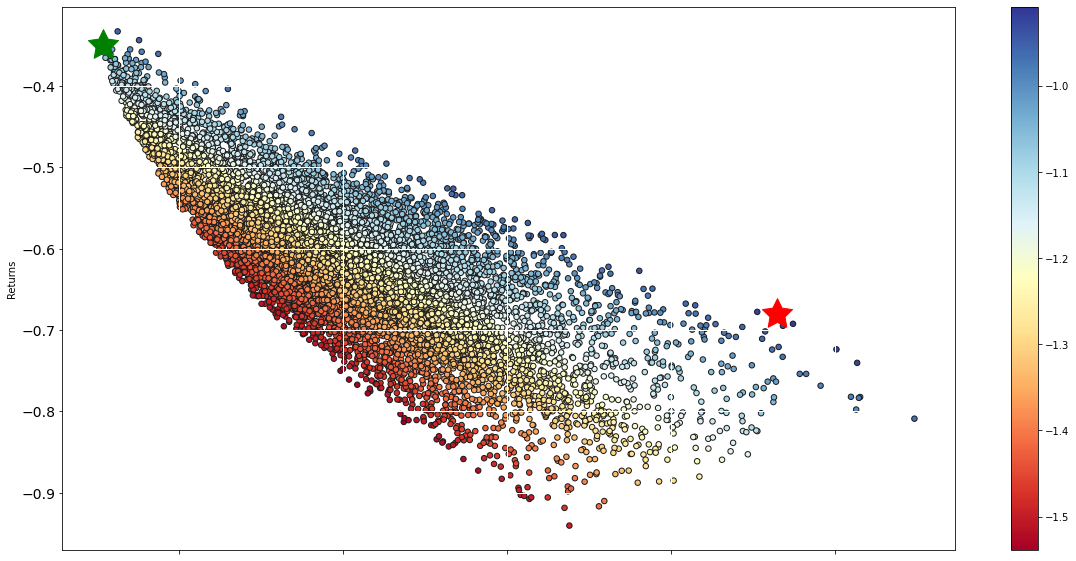

In [27]:
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show()